# Write LORS

In [1]:
import Pkg

In [3]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase", "PhysicalConstants"]);

In [6]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [7]:
Pkg.add("Distributions") 

In [1]:
#using Distributions

In [2]:
#using LsqFit
#using GLM
#using HTTP
#using Test

In [1]:
using Plots
using DataFrames
using HDF5
using DrWatson
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [2]:
using Glob
using CSV

In [3]:
using Statistics
using StatsBase
using Printf

In [4]:
using Logging

In [19]:
@quickactivate "JPetalo"

In [6]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [7]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [8]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [187]:
include(srcdir("JPetalo.jl"))

Main.JPetalo

In [10]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, ps, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J,
	mW, μW, W,
    A, N, mol, mmol, V, L, mL, μL, M

In [11]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

In [12]:
loglevel("Warn")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

## Read data file with nema events (merged data frames)

In [109]:
function readmdf(dir="n3mdf-50ps", sipm="naked", proc="phot", reco="phistd")
    dir      = datadir(dir)
    file     = "mdf-$reco-$sipm-$proc.csv"
    filename = string(dir,"/",file)
    return filename, DataFrame(CSV.File(filename))
end
    

readmdf (generic function with 5 methods)

In [212]:
function dftolor(df::DataFrame, t::JPetalo.Dtsel=JPetalo.dtfirst, 
                 position::JPetalo.Possel=JPetalo.postrue, reco="none", nlxe::Number=1.6)

    function tof32(l)
        Float32.(l/mm)
    end

    dt12  = JPetalo.deltatime(df,t)
    dtdoi = JPetalo.cdoi(df,position,reco)
    # compute dx from time and speed of light, ensure that the result is in mm
    dx    = uconvert.(mm, (dt12 - dtdoi) * SpeedOfLightInVacuum)

    if position == JPetalo.postrue
        x1, x2, y1, y2, z1, z2 = df.xt1, df.xt2, df.yt1, df.yt2, df.zt1, df.zt2
    elseif position == JPetalo.posreco
        x1, x2, y1, y2, z1, z2 = df.x1,  df.x2,  df.y1,  df.y2,  df.z1,  df.z2
    elseif position == JPetalo.posrecall
        if reco == "phistd"
            x1,y1,z1 = JPetalo.radial_correction(df.xr1./mm, df.yr1./mm, df.zr1./mm, df.r1p./mm)
            x2,y2,z2 = JPetalo.radial_correction(df.xr2./mm, df.yr2./mm, df.zr2./mm, df.r2p./mm)
        elseif reco == "zstd"
            x1,y1,z1 = JPetalo.radial_correction(df.xr1./mm, df.yr1./mm, df.zr1./mm, df.r1z./mm)
            x2,y2,z2 = JPetalo.radial_correction(df.xr2./mm, df.yr2./mm, df.zr2./mm, df.r2z./mm)
        else
            println("reco options can only be phistd or zstd returning nothing")
            return nothing
        end
        return JPetalo.MlemLor.(tof32(dx),Float32.(x1),Float32.(y1),Float32.(z1), 
                                Float32.(x2), Float32.(y2), Float32.(z2))  
    end

    return JPetalo.MlemLor.(tof32(dx),tof32(x1),tof32(y1),tof32(z1), tof32(x2), tof32(y2), tof32(z2))
end

dftolor (generic function with 13 methods)

## Read mdf files

In [290]:
mdfdir = "n3mdf-50ps"
lordir = "n3lor-50ps"
sipm = "quartz"
proc ="phot"

filename, mdfp  = readmdf(mdfdir, sipm, proc, "phistd")
println("reading ", filename, " length =", nrow(mdfp))
filename, mdfz  = readmdf(mdfdir, sipm, proc, "zstd")
println("reading ", filename, " length =", nrow(mdfz))
dfup = JPetalo.setunits(mdfp, "phistd")
dfuz = JPetalo.setunits(mdfz, "zstd")
println("phistd DF =", names(dfup))
println("zstd DF =", names(dfuz))

reading /Users/jj/JuliaProjects/JPetalo/data/n3mdf-50ps/mdf-phistd-quartz-phot.csv length =12697
reading /Users/jj/JuliaProjects/JPetalo/data/n3mdf-50ps/mdf-zstd-quartz-phot.csv length =6105
phistd DF =["nsipm1", "nsipm2", "q1", "q2", "r1", "r2", "r1p", "r2p", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zt1", "zt2"]
zstd DF =["nsipm1", "nsipm2", "q1", "q2", "r1", "r2", "r1z", "r2z", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zt1", "zt2"]


## Write LORS

In [291]:
lors_first_true   = dftolor(dfup, JPetalo.dtfirst, JPetalo.postrue);
JPetalo.write_lors_hdf5(datadir("$(lordir)/lors-$(sipm)-$(proc)-first-true.h5"), lors_first_true)

In [292]:
lors_minimum_reco   = dftolor(dfup, JPetalo.dtminimum, JPetalo.posreco)
JPetalo.write_lors_hdf5(datadir("$(lordir)/lors-$(sipm)-$(proc)-minimum-reco.h5"), lors_minimum_reco)

In [293]:
lors_minimum_recall_phistd   = dftolor(dfup, JPetalo.dtminimum, JPetalo.posrecall, "phistd")
JPetalo.write_lors_hdf5(datadir("$(lordir)/lors-$(sipm)-$(proc)-minimum-recall-phistd.h5"), lors_minimum_recall_phistd)

In [294]:
lors_minimum_recall_zstd   = dftolor(dfuz, JPetalo.dtminimum, JPetalo.posrecall, "zstd")
JPetalo.write_lors_hdf5(datadir("$(lordir)/lors-$(sipm)-$(proc)-minimum-recall-zstd.h5"), lors_minimum_recall_zstd)

## Control

## q1 vs q2

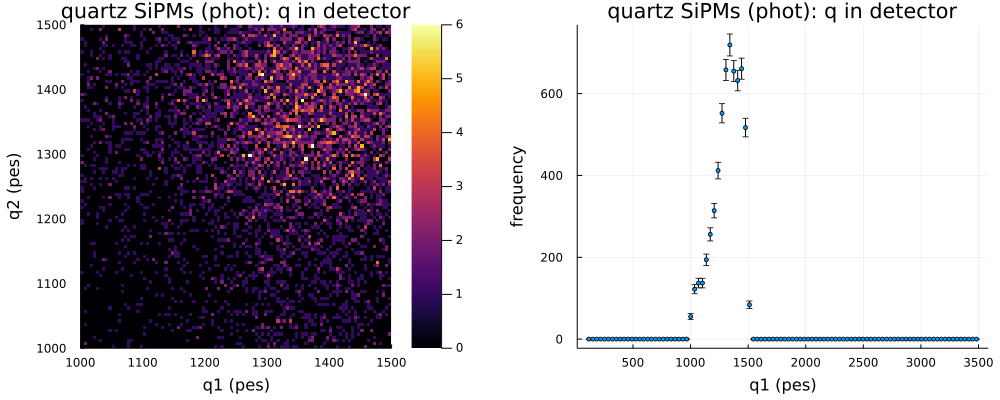

In [296]:
JPetalo.q1vsq2(mdfz, tit="$sipm SiPMs ($proc): q in detector", filename="q1q2-$sipm-$proc")

## ZSTD

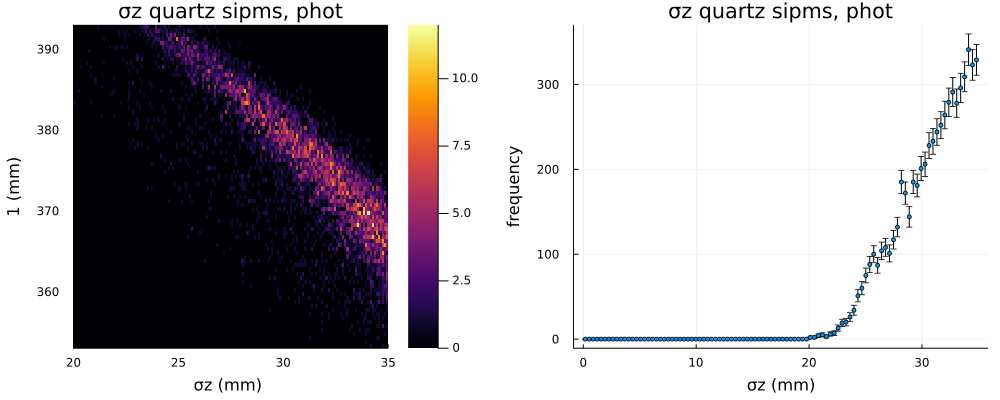

In [297]:
JPetalo.zstd(mdfz, tit="σz $sipm sipms, $proc", filename="zstd-$sipm-$proc")

 σ =     2.9 mm

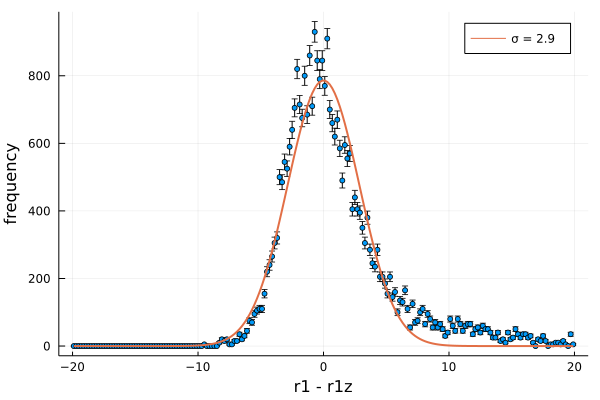

In [298]:
fg,p = JPetalo.fitg1(mdfz.r1z - mdfz.r1, "r1 - r1z", 200, -20.0, 20.0, xgmin=-10.0, xgmax=10.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(p)

 σ =     3.0 mm

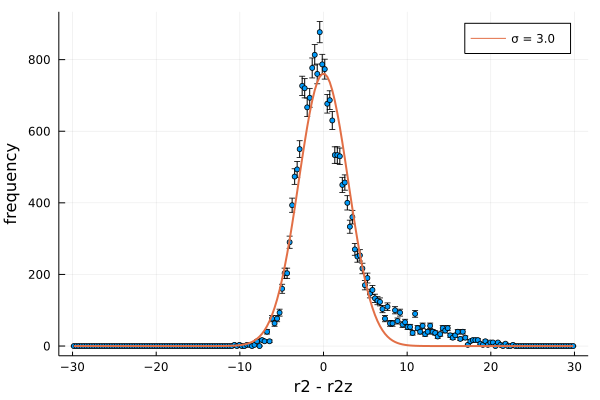

In [299]:
fg,p = JPetalo.fitg1(mdfz.r2z - mdfz.r2, "r2 - r2z", 200, -30.0, 30.0, xgmin=-10.0, xgmax=10.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(p)

## PhiSTD

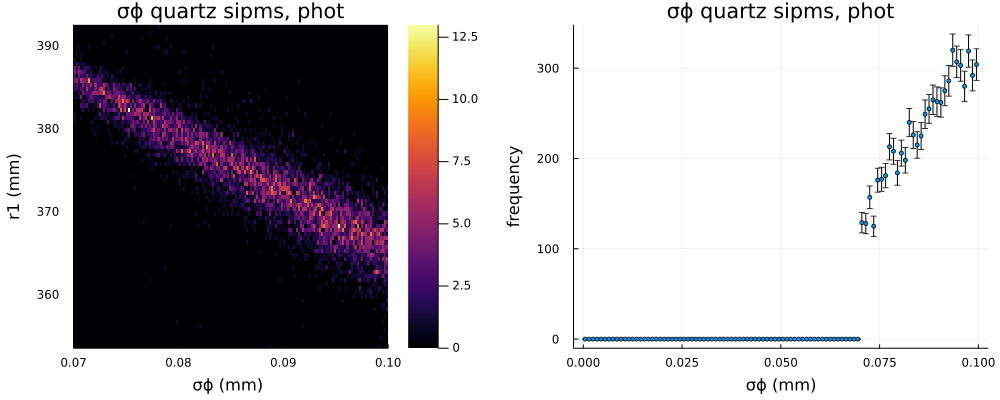

In [300]:
JPetalo.phistd(mdfp,tit="σϕ $sipm sipms, $proc", filename="phistd-$sipm-$proc")

 σ =     2.5 mm

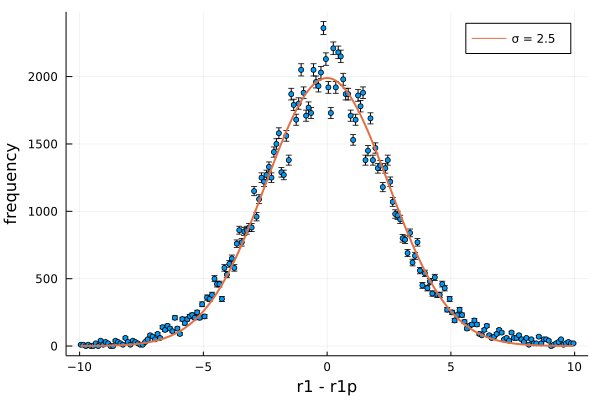

In [305]:
fg,pg = JPetalo.fitg1(mdfp.r1 - mdfp.r1p, "r1 - r1p", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(pg)

In [306]:
@printf "Resolution in R (σϕ estimaor) FWHM = %7.1f %s" 2.3 * fg.std[1] "mm" 

Resolution in R (σϕ estimaor) FWHM =     5.7 mm

 σ =     2.4 mm

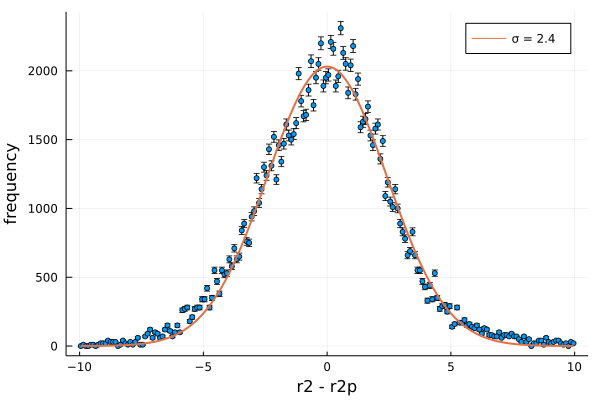

In [307]:
fg,pg = JPetalo.fitg1(mdfp.r2 - mdfp.r2p, "r2 - r2p", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(pg)

## Position from best estimator (r1p)

In [308]:
xp1,yp1,zp1 = JPetalo.radial_correction(mdfp.xr1, mdfp.yr1, mdfp.zr1, mdfp.r1p);
xp2,yp2,zp2 = JPetalo.radial_correction(mdfp.xr2, mdfp.yr2, mdfp.zr2, mdfp.r2p);

In [309]:
fg,px1g1 = JPetalo.fitg1(mdfp.xt1 - xp1, "xt-xp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(px1g1);

 σ =     1.9 mm

In [310]:
fg, px1g2 = JPetalo.fitg2(mdfp.xt1 - xp1, "xt-xr", 200, -10.0, 10.0, 
                      xg1min=-10.0, xg1max=-3.0, 
                      xg2min=-3.0,  xg2max =3.0, 
                      xgmin =-10.0, xgmax  =10.0)
@printf "sigma1 = %7.3f sigma2 = %7.3f" fg.std[1] fg.std[2]
plot(px1g2);

sigma1 =   2.583 sigma2 =   1.521

In [311]:
@printf " resolution in (x,y,z) FWHM  = %7.1f mm" 2.3 * fg.std[2] 

 resolution in (x,y,z) FWHM  =     3.5 mm

In [312]:
fg,py1 = JPetalo.fitg1(mdfp.yt1 - yp1, "yt-yr", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(py1);

 σ =     2.1 mm

In [313]:
fg,pz1 = JPetalo.fitg1(mdfp.zt1 - zp1, "zt-zr", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(pz1);

 σ =     1.5 mm

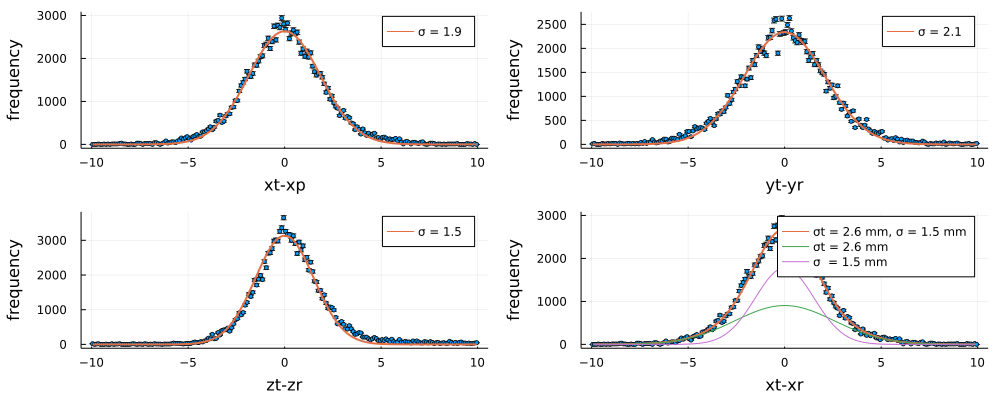

In [314]:
plot(px1g1, py1, pz1, px1g2,  layout= (2, 2), legend=true, fmt = :png,  size = (1000, 400),
        left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)


In [315]:
fg,px2 = JPetalo.fitg1(mdfp.xt2 - xp2, "xt2-xr2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(px2);

 σ =     1.8 mm

In [316]:
fg, px2g2 = JPetalo.fitg2(mdfp.xt2 - xp2, "xt2-xr2", 200, -10.0, 10.0, 
                      xg1min=-10.0, xg1max=-3.0, 
                      xg2min=-3.0,  xg2max =3.0, 
                      xgmin =-10.0, xgmax  =10.0)
@printf "sigma1 = %7.3f sigma2 = %7.3f" fg.std[1] fg.std[2]
plot(px2g2);

sigma1 =   2.578 sigma2 =   1.475

In [317]:
fg,py2 = JPetalo.fitg1(mdfp.yt2 - yp2, "yt2-yr2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(py2);

 σ =     2.1 mm

In [318]:
fg, pz2 = JPetalo.fitg2(mdfp.zt2 - zp2, "zt2-zr2",  200, -20.0, 20.0, 
                      xg1min=-20.0, xg1max=-3.0, 
                      xg2min=-3.0,  xg2max =3.0, 
                      xgmin =-20.0, xgmax  =20.0)
@printf "sigma1 = %7.3f sigma2 = %7.3f" fg.std[1] fg.std[2]
plot(pz2);

sigma1 =   3.452 sigma2 =   1.353

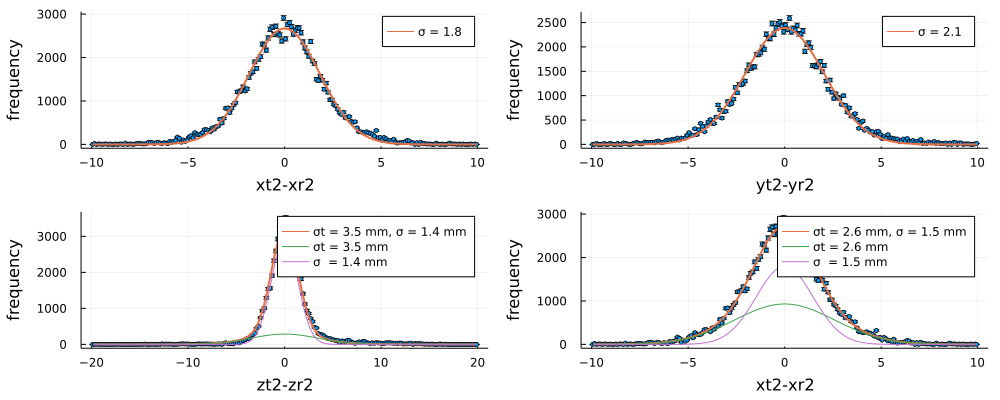

In [319]:
plot(px2, py2, pz2, px2g2,  layout= (2, 2), legend=true, fmt = :png,  size = (1000, 400),
        left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)


In [320]:
xz1,yz1,zz1 = JPetalo.radial_correction(mdfz.xr1, mdfz.yr1, mdfz.zr1, mdfz.r1z);
xz2,yz2,zz2 = JPetalo.radial_correction(mdfz.xr2, mdfz.yr2, mdfz.zr2, mdfz.r2z);

In [321]:
fg,pzx1 = JPetalo.fitg1(mdfz.xt1 - xz1, "xt-xz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(pzx1);

 σ =     1.9 mm

In [322]:
fg,pzy1 = JPetalo.fitg1(mdfz.yt1 - yz1, "yt-yz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(pzy1);

 σ =     2.0 mm

In [323]:
fg,pzz1 = JPetalo.fitg1(mdfz.zt1 - zz1, "zt-zz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(pzz1);

 σ =     1.2 mm

In [324]:
fg,pzx2 = JPetalo.fitg1(mdfz.xt2 - xz2, "xt2-xz2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(pzx2);

 σ =     1.9 mm

In [325]:
fg,pzy2 = JPetalo.fitg1(mdfz.yt2 - yz2, "yt2-yz2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(pzy2);

 σ =     2.1 mm

In [326]:
fg,pzz2 = JPetalo.fitg1(mdfz.zt2 - zz2, "zt2-zz2", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σ = %7.1f mm" fg.std[1] 
plot(pzz2);

 σ =     1.2 mm

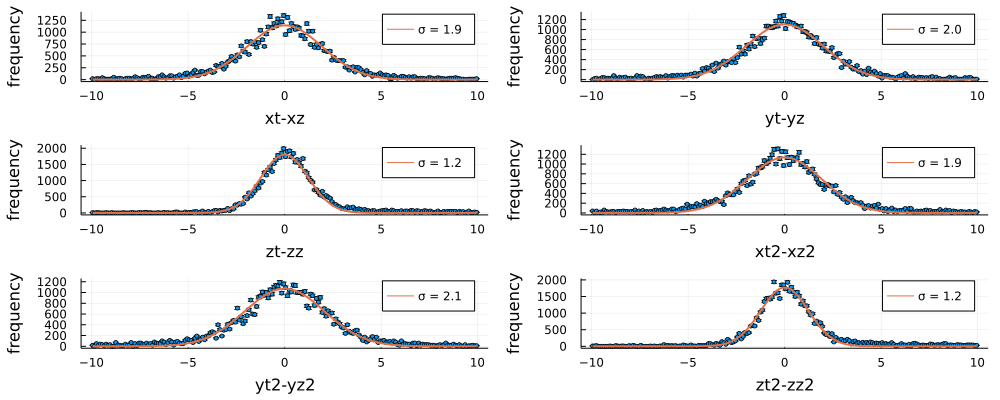

In [327]:
plot(pzx1, pzy1, pzz1, pzx2, pzy2, pzz2,  layout= (3, 2), legend=true, fmt = :png,  size = (1000, 400),
        left_margin=5Plots.mm, right_margin=1Plots.mm, bottom_margin=5Plots.mm)


## TOF

average photoelectron, position reco: FWHM = 354.028

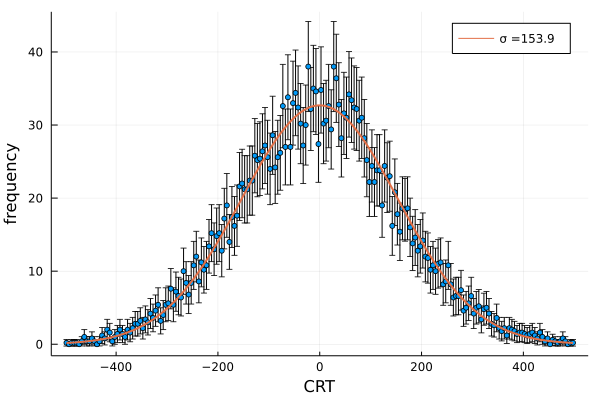

In [328]:
dt = JPetalo.crt(dfup, dfup.r1p./mm, dfup.r2p./mm, JPetalo.dtaverage,JPetalo.posrecall)
fg,p = JPetalo.fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "average photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
plot(p)

average photoelectron, position reco: FWHM = 300.873

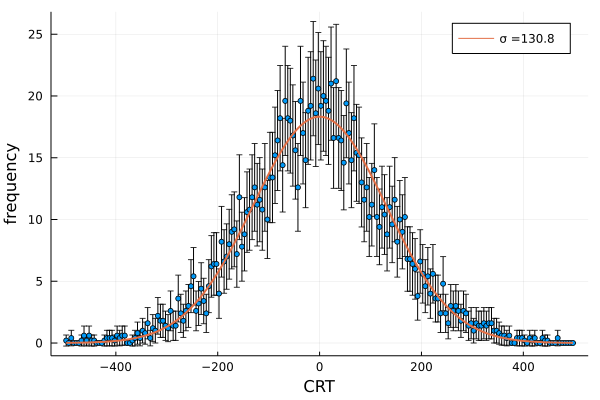

In [329]:
dt = JPetalo.crt(dfuz, dfuz.r1z./mm, dfuz.r2z./mm, JPetalo.dtaverage,JPetalo.posrecall)
fg,p = JPetalo.fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "average photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
plot(p)